In [5]:
import zipfile
import pandas as pd
import numpy as np
from PIL import Image
import io

# List of paths to your zip files 
# The four zip files should be:
# 1. inpainting.zip
# 2. insight.zip
# 3. text2img.zip
# 4. wiki.zip (contains real images)

#Make sure you do not commit the data to the repository
#Also make sure to not upload your paths to the repository


zip_paths = [
    'INSERT PATH HERE/inpainting.zip',
    'INSERT PATH HERE/insight.zip',
    'INSERT PATH HERE/text2img.zip',
    'INSERT PATH HERE/wiki.zip'
]

# Function to add image data to a DataFrame from multiple zip files
def create_image_dataframe(zip_paths):
    # List to store image data
    data = []

    # Process each zip file
    for zip_path in zip_paths:
        print(f"Processing zip file: {zip_path}")  # Print current zip file being processed
        with zipfile.ZipFile(zip_path, 'r') as z:
            # Get the main folder (the only folder directly under the zip file)
            main_folder = next((item for item in z.namelist() if '/' in item and item.endswith('/')), None)
            if not main_folder:
                continue

            # Extract subfolders from the main folder
            subfolders = set([item[len(main_folder):].split('/')[0] for item in z.namelist() if item.startswith(main_folder) and '/' in item])

            # Select only the first two subfolders
            selected_subfolders = list(subfolders)[:2]
            print(f"Selected subfolders in {main_folder}: {selected_subfolders}")  # Print the selected subfolders

            # Iterate over each item in the selected two subfolders
            for file in z.namelist():
                folder_name = file[len(main_folder):].split('/')[0]
                if folder_name in selected_subfolders:
                    # Check if the item is a file and is an image
                    if file.endswith(('.png', '.jpg', '.jpeg')) and '/' in file:
                        # Read the image
                        image_data = z.read(file)
                        image = Image.open(io.BytesIO(image_data))

                        # Convert image to grayscale and resize
                        image = image.convert('L').resize((128, 128), Image.LANCZOS)
                        img_array = np.array(image)

                        # Determine if the image is a deepfake or not based on the zip file
                        is_deep_fake = not zip_path.endswith('wiki.zip')

                        # Append image information to the list
                        data.append({
                            'Zip Folder': zip_path,
                            'Image Path': f"{zip_path}/{folder_name}/{file}",
                            'Is DeepFake': is_deep_fake,
                            'Image Data': img_array.flatten()  # Flatten the array
                        })

                        #print(f"Processed image: {file}")  # Print each processed image file

    # Convert list to DataFrame
    df = pd.DataFrame(data)
    return df

# Call the function and store the DataFrame
df_images = create_image_dataframe(zip_paths)

Processing zip file: C:/Users/Owner/Documents/GitHub/DeepFake Data/inpainting.zip
Selected subfolders in inpainting/: ['', '45']
Processing zip file: C:/Users/Owner/Documents/GitHub/DeepFake Data/insight.zip
Selected subfolders in insight/: ['', '45']
Processing zip file: C:/Users/Owner/Documents/GitHub/DeepFake Data/text2img.zip
Selected subfolders in text2img/: ['', '45']
Processing zip file: C:/Users/Owner/Documents/GitHub/DeepFake Data/wiki.zip
Selected subfolders in wiki/: ['', '45']


In [6]:
image_counts = df_images['Zip Folder'].value_counts()
print("\nNumber of images from each zip folder:")
print(image_counts)


Number of images from each zip folder:
Zip Folder
C:/Users/Owner/Documents/GitHub/DeepFake Data/inpainting.zip    318
C:/Users/Owner/Documents/GitHub/DeepFake Data/insight.zip       318
C:/Users/Owner/Documents/GitHub/DeepFake Data/text2img.zip      318
C:/Users/Owner/Documents/GitHub/DeepFake Data/wiki.zip          318
Name: count, dtype: int64


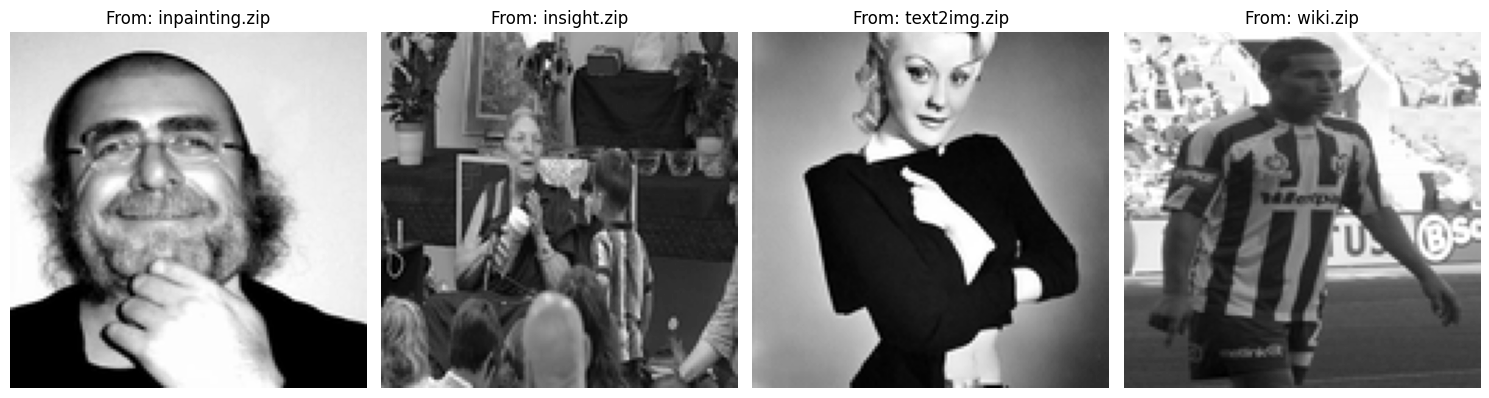

In [14]:
import matplotlib.pyplot as plt
import random

def display_random_images_from_each_zip(df_images):
    # Find unique zip folders
    unique_zip_folders = df_images['Zip Folder'].unique()

    fig, axes = plt.subplots(1, len(unique_zip_folders), figsize=(15, 5))

    # Loop through each unique zip folder
    for i, zip_folder in enumerate(unique_zip_folders):
        # Filter the DataFrame for images only from the current zip folder
        folder_images = df_images[df_images['Zip Folder'] == zip_folder]
        
        # Select a random image from this folder
        random_index = random.randint(0, len(folder_images) - 1)
        image_row = folder_images.iloc[random_index]
        image_data = image_row['Image Data'].reshape(128, 128)  # Reshape the flattened array back to 128x128

        # Plot the image
        ax = axes[i]
        ax.imshow(image_data, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"From: {zip_folder.split('/')[-1]}")

    plt.tight_layout()
    plt.show()

# Call the function to display the images
display_random_images_from_each_zip(df_images)
